In [1]:
from victim_circuit_gen import victim_gen

In [2]:
from qiskit import QuantumCircuit
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# Parameters

In [23]:
snooper_qubits = (1, 4, 6)
victim_qubits = (3, 5)
ibm_backend_name = 'ibm_nairobi'

max_circuit_depth = 50
cnot_vals = list(range(20))
no_of_circuits_per_cnot_val = 60

In [4]:
provider = IBMProvider()
backend = provider.get_backend(ibm_backend_name)

# Methods

In [5]:
def init_snoopers(num_of_snoopers):
    '''
        num_of_snoopers: # of snooper qubits
        create a barrier after this and then add the victim qc
    '''
    qc = QuantumCircuit(num_of_snoopers)
    qc.h(range(num_of_snoopers))
    return qc

def readout_snoopers(num_of_snoopers):
    '''
        num_of_snoopers: # of snooper qubits
        create a barrier before this
    '''
    qc = QuantumCircuit(num_of_snoopers)
    qc.h(range(num_of_snoopers))
    qc.measure_all()
    return qc

# One-way CNOT victim circuits

## Create victim circuits

In [ ]:
victim_qcs = []
for no_of_cnots in cnot_vals:
    for _ in range(no_of_circuits_per_cnot_val):
        victim_qc = victim_gen.random_2_qubit_circuit_one_way_cnot(no_of_cnots, np.random.randint(no_of_cnots, max_circuit_depth))
        victim_qcs.append(victim_qc)

## Create full circuit for IBM Backend

In [ ]:
qc1 = init_snoopers(len(snooper_qubits))
qc2 = readout_snoopers(len(snooper_qubits))

In [ ]:
qcs: list[QuantumCircuit] = []
for victim_qc in victim_qcs:
    qc = QuantumCircuit(backend.num_qubits, len(snooper_qubits))
    qc.append(qc1, snooper_qubits)
    qc.barrier()
    qc.append(victim_qc, victim_qubits)
    qc.barrier()
    qc.append(qc2, snooper_qubits, range(len(snooper_qubits)))
    qcs.append(qc.decompose())

In [ ]:
pm = generate_preset_pass_manager(0, backend)

In [ ]:
tqcs = pm.run(qcs)
job = backend.run(tqcs, shots=8000)
job.update_tags(['snooping', 'one_way_cnot'])
print('New job: ', job.job_id())

## Checkpoint

In [49]:
job_id = 'cgc7scc87iti7tpf2390'
job = provider.backend.retrieve_job(job_id)

## Analyse Results

In [50]:
tqcs = job.circuits()
qc_res_counts = job.result().get_counts()

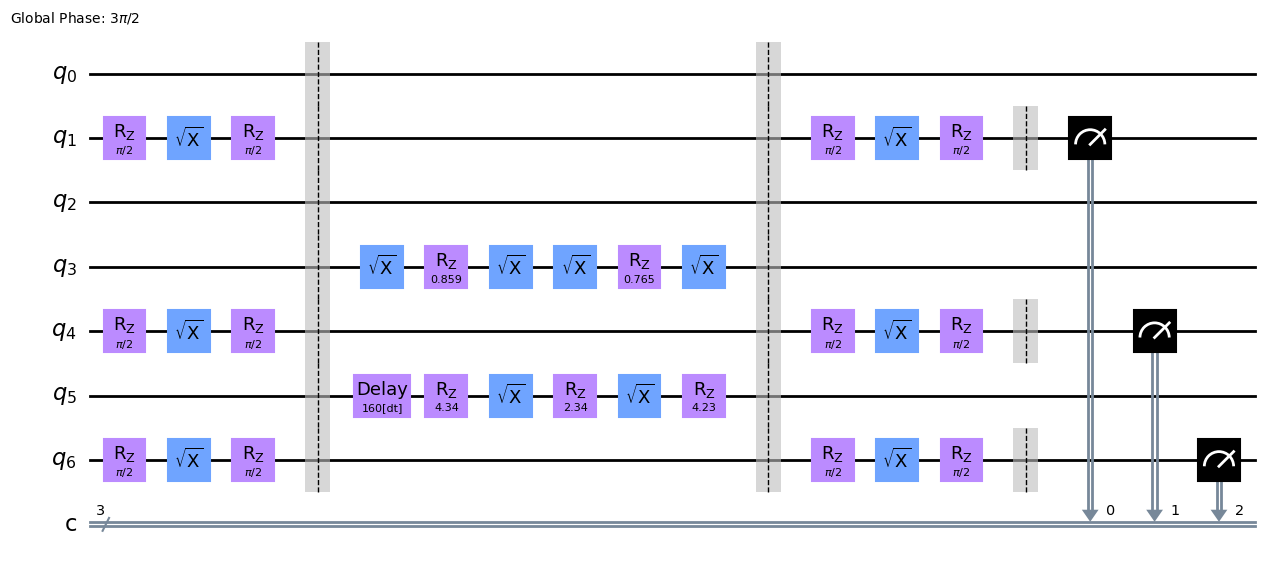

In [51]:
tqcs[0].draw('mpl')

In [26]:
import os
path = 'results/{}/{}'.format(job.backend().name, job.job_id())
path_exists = os.path.exists(path)
if not path_exists:
   os.makedirs(path)

In [27]:
if not path_exists:
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = qc_res_counts[start_index: start_index+no_of_circuits_per_cnot_val]
        title='CNOTs-{}'.format(cnot_count)
        fig, axs = plt.subplots()
        plot_histogram(data, ax=axs, title=title)
        fig.savefig('{}/{}.png'.format(path, title))

Stats on depths of circuits

In [28]:
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    depths = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        depths.append(tqcs[i].depth())
    print(cnot_count, stats.describe(depths))

0 DescribeResult(nobs=60, minmax=(7, 56), mean=29.866666666666667, variance=200.76158192090392, skewness=0.3270393359236559, kurtosis=-0.9067922188961726)
1 DescribeResult(nobs=60, minmax=(8, 55), mean=31.4, variance=196.4474576271186, skewness=0.17417256454023516, kurtosis=-1.1239153374250432)
2 DescribeResult(nobs=60, minmax=(9, 56), mean=32.05, variance=248.62457627118644, skewness=0.08509168650119735, kurtosis=-1.403122658221762)
3 DescribeResult(nobs=60, minmax=(12, 56), mean=32.68333333333333, variance=167.84717514124293, skewness=0.2975409972356424, kurtosis=-1.022239339105107)
4 DescribeResult(nobs=60, minmax=(12, 55), mean=31.383333333333333, variance=171.73192090395477, skewness=0.072923096685296, kurtosis=-1.3342931590488851)
5 DescribeResult(nobs=60, minmax=(12, 56), mean=34.31666666666667, variance=183.50819209039545, skewness=-0.18850681664277535, kurtosis=-1.3055896530187934)
6 DescribeResult(nobs=60, minmax=(13, 56), mean=35.28333333333333, variance=137.7997175141243, s

Stats on 000 measurements

In [29]:
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    data = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        data.append(qc_res_counts[i]['000'])
    print(cnot_count, stats.describe(data))


0 DescribeResult(nobs=60, minmax=(6172, 7809), mean=7342.083333333333, variance=172859.77259887004, skewness=-0.9702315014285181, kurtosis=0.017847030605854464)
1 DescribeResult(nobs=60, minmax=(5664, 7632), mean=6894.916666666667, variance=282146.8573446328, skewness=-0.5577346334390411, kurtosis=-0.7761741688832573)
2 DescribeResult(nobs=60, minmax=(4938, 7338), mean=6404.366666666667, variance=490355.28700564965, skewness=-0.48020227042489183, kurtosis=-0.8528624736855313)
3 DescribeResult(nobs=60, minmax=(4238, 6864), mean=5810.383333333333, variance=446767.2912429379, skewness=-0.4844582272270718, kurtosis=-0.8331085145936576)
4 DescribeResult(nobs=60, minmax=(3985, 6380), mean=5263.516666666666, variance=432172.32175141247, skewness=-0.10975388439751903, kurtosis=-1.2394697941274881)
5 DescribeResult(nobs=60, minmax=(2859, 5509), mean=4486.633333333333, variance=437479.28700564976, skewness=-0.10596437918002903, kurtosis=-0.9799053793349177)
6 DescribeResult(nobs=60, minmax=(2690

In [30]:
dataa = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    data = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        data.append(qc_res_counts[i]['000'])
    dataa.append(data)

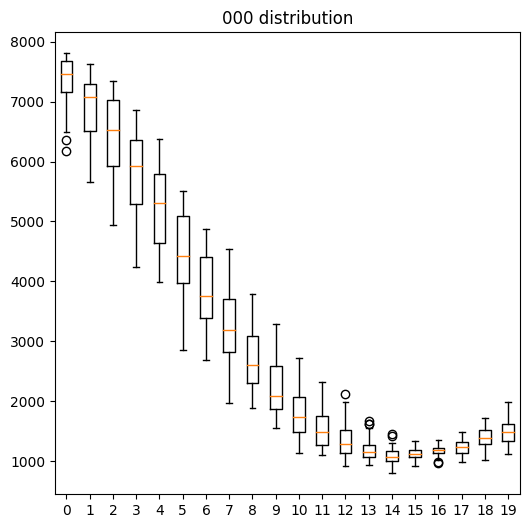

In [31]:
fig, axs = plt.subplots(figsize=(6, 6))
title = '000 distribution'
axs.set_title(title)
axs.boxplot(dataa, labels=cnot_vals)
plt.show(fig)
if not path_exists:
    fig.savefig('{}/{}.png'.format(path, title))


# Two-way CNOTs victim circuits

## Create victim circuits

In [ ]:
victim_qcs = []
for no_of_cnots in cnot_vals:
    for _ in range(no_of_circuits_per_cnot_val):
        victim_qc = victim_gen.random_2_qubit_circuit_two_way_cnot(no_of_cnots, np.random.randint(no_of_cnots, max_circuit_depth))
        victim_qcs.append(victim_qc)

## Create full circuit for IBM Backend

In [ ]:
qc1 = init_snoopers(len(snooper_qubits))
qc2 = readout_snoopers(len(snooper_qubits))

In [ ]:
qcs: list[QuantumCircuit] = []
for victim_qc in victim_qcs:
    qc = QuantumCircuit(backend.num_qubits, len(snooper_qubits))
    qc.append(qc1, snooper_qubits)
    qc.barrier()
    qc.append(victim_qc, victim_qubits)
    qc.barrier()
    qc.append(qc2, snooper_qubits, range(len(snooper_qubits)))
    qcs.append(qc.decompose())

In [ ]:
pm = generate_preset_pass_manager(0, backend)

In [ ]:
tqcs = pm.run(qcs)
job = backend.run(tqcs, shots=8000)
job.update_tags(['snooping', 'two_way_cnot'])
print('New job: ', job.job_id())

## Checkpoint

In [32]:
job_id = 'cgc96m487iti7tpg5a30'
job = provider.backend.retrieve_job(job_id)

## Analyse Results

In [33]:
tqcs = job.circuits()
qc_res_counts = job.result().get_counts()

In [34]:
import os
path = 'results/{}/{}'.format(job.backend().name, job.job_id())
path_exists = os.path.exists(path)
if not path_exists:
   os.makedirs(path)

In [35]:
if not path_exists:
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = qc_res_counts[start_index: start_index+no_of_circuits_per_cnot_val]
        title='CNOTs-{}'.format(cnot_count)
        fig = plot_histogram(data, title=title)
        fig.savefig('{}/{}.png'.format(path, title))

Stats on depths of circuits

In [36]:
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    depths = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        depths.append(tqcs[i].depth())
    print(cnot_count, stats.describe(depths))

0 DescribeResult(nobs=60, minmax=(8, 56), mean=31.716666666666665, variance=235.4268361581921, skewness=0.11904396630299095, kurtosis=-1.3307710719982229)
1 DescribeResult(nobs=60, minmax=(8, 55), mean=31.233333333333334, variance=178.58870056497176, skewness=0.02904448399607829, kurtosis=-1.1345635806895427)
2 DescribeResult(nobs=60, minmax=(9, 56), mean=31.433333333333334, variance=215.47005649717516, skewness=0.12117206253642061, kurtosis=-1.3046505704529494)
3 DescribeResult(nobs=60, minmax=(11, 56), mean=34.88333333333333, variance=228.30819209039547, skewness=-0.06220270491326226, kurtosis=-1.4623840624557627)
4 DescribeResult(nobs=60, minmax=(11, 55), mean=31.9, variance=145.75254237288135, skewness=0.14709928404610687, kurtosis=-0.93790461057241)
5 DescribeResult(nobs=60, minmax=(14, 54), mean=31.466666666666665, variance=111.71073446327682, skewness=0.42097716913775807, kurtosis=-0.6201142682769767)
6 DescribeResult(nobs=60, minmax=(13, 56), mean=35.5, variance=155.40677966101

Stats on measurements

In [37]:
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    data = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        data.append(qc_res_counts[i]['000'])
    print(cnot_count, stats.describe(data))


0 DescribeResult(nobs=60, minmax=(6044, 7808), mean=7262.683333333333, variance=211455.3387005649, skewness=-0.69791854788415, kurtosis=-0.5424160804979099)
1 DescribeResult(nobs=60, minmax=(5953, 7630), mean=6928.416666666667, variance=218426.72175141238, skewness=-0.23978569775596822, kurtosis=-0.9401074885921834)
2 DescribeResult(nobs=60, minmax=(5056, 7331), mean=6460.95, variance=398605.53983050847, skewness=-0.2758346868468463, kurtosis=-1.1113106215709256)
3 DescribeResult(nobs=60, minmax=(4318, 6952), mean=5765.116666666667, variance=561630.206497175, skewness=-0.2606909961676205, kurtosis=-1.2001524258117906)
4 DescribeResult(nobs=60, minmax=(3619, 6351), mean=5307.9, variance=427105.0745762711, skewness=-0.2509346696440756, kurtosis=-0.6828003197464976)
5 DescribeResult(nobs=60, minmax=(3567, 5818), mean=4838.6, variance=297759.0576271186, skewness=-0.42543753327383027, kurtosis=-0.49307306036918463)
6 DescribeResult(nobs=60, minmax=(2922, 5165), mean=3990.45, variance=364526

In [38]:
dataa = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    data = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        data.append(qc_res_counts[i]['000'])
    dataa.append(data)

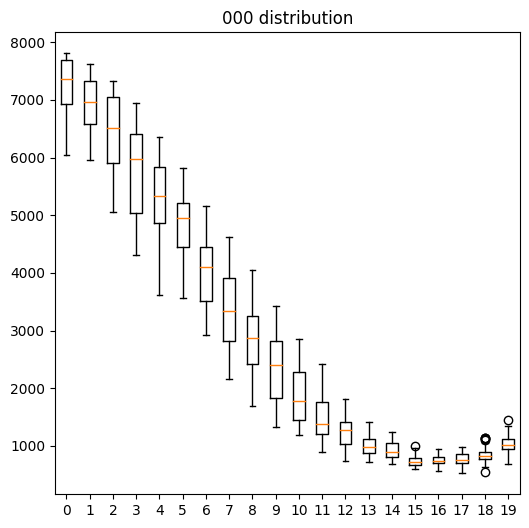

In [39]:
fig, axs = plt.subplots(figsize=(6, 6))
title = '000 distribution'
axs.set_title(title)
axs.boxplot(dataa, labels=cnot_vals)
plt.show(fig)
if not path_exists:
    fig.savefig('{}/{}.png'.format(path, title))



# Two-way CNOTs victim circuits with gap

## Parameters

In [40]:
snooper_qubits = (0,)
victim_qubits = (3, 5)

## Create victim circuits

In [ ]:
victim_qcs = []
for no_of_cnots in cnot_vals:
    for _ in range(no_of_circuits_per_cnot_val):
        victim_qc = victim_gen.random_2_qubit_circuit_two_way_cnot(no_of_cnots, np.random.randint(no_of_cnots, max_circuit_depth))
        victim_qcs.append(victim_qc)

## Create full circuit for IBM Backend

In [ ]:
qc1 = init_snoopers(len(snooper_qubits))
qc2 = readout_snoopers(len(snooper_qubits))

In [ ]:
qcs: list[QuantumCircuit] = []
for victim_qc in victim_qcs:
    qc = QuantumCircuit(backend.num_qubits, len(snooper_qubits))
    qc.append(qc1, snooper_qubits)
    qc.barrier()
    qc.append(victim_qc, victim_qubits)
    qc.barrier()
    qc.append(qc2, snooper_qubits, range(len(snooper_qubits)))
    qcs.append(qc.decompose())

In [ ]:
pm = generate_preset_pass_manager(0, backend)

In [ ]:
tqcs = pm.run(qcs)
job = backend.run(tqcs, shots=8000)
job.update_tags(['snooping', 'two_way_cnot', 'gap'])
print('New job: ', job.job_id())

## Checkpoint

In [41]:
job_id = 'cgcbrneeecr5v10vgo00'
job = provider.backend.retrieve_job(job_id)

## Analyse Results

In [42]:
tqcs = job.circuits()
qc_res_counts = job.result().get_counts()

In [43]:
import os
path = 'results/{}/{}'.format(job.backend().name, job.job_id())
path_exists = os.path.exists(path)
if not path_exists:
   os.makedirs(path)

In [44]:
if not path_exists:
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = qc_res_counts[start_index: start_index+no_of_circuits_per_cnot_val]
        title='CNOTs-{}'.format(cnot_count)
        fig = plot_histogram(data, title=title)
        fig.savefig('{}/{}.png'.format(path, title))

Stats on depths of circuits

In [45]:
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    depths = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        depths.append(tqcs[i].depth())
    print(cnot_count, stats.describe(depths))

0 DescribeResult(nobs=60, minmax=(9, 56), mean=29.583333333333332, variance=190.3488700564972, skewness=0.22255737654445726, kurtosis=-1.1379871458524786)
1 DescribeResult(nobs=60, minmax=(8, 54), mean=32.583333333333336, variance=175.60310734463278, skewness=-0.14221584005096705, kurtosis=-1.0938773398825967)
2 DescribeResult(nobs=60, minmax=(9, 56), mean=32.0, variance=216.27118644067795, skewness=-0.007674106483779805, kurtosis=-1.232222560705968)
3 DescribeResult(nobs=60, minmax=(11, 56), mean=33.78333333333333, variance=193.7997175141243, skewness=-0.17733908928379713, kurtosis=-1.2844806445133576)
4 DescribeResult(nobs=60, minmax=(11, 53), mean=32.1, variance=138.63389830508473, skewness=0.09417857872504819, kurtosis=-1.0346807798561999)
5 DescribeResult(nobs=60, minmax=(12, 56), mean=32.833333333333336, variance=177.49717514124293, skewness=0.13188296073415712, kurtosis=-1.0629807057052667)
6 DescribeResult(nobs=60, minmax=(13, 56), mean=35.55, variance=196.0822033898305, skewne

Stats on 000 measurements

In [46]:
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    data = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        data.append(qc_res_counts[i]['0'])
    print(cnot_count, stats.describe(data))


0 DescribeResult(nobs=60, minmax=(7541, 7914), mean=7791.116666666667, variance=8695.223446327684, skewness=-0.6677399539149816, kurtosis=-0.40305367977908624)
1 DescribeResult(nobs=60, minmax=(7490, 7870), mean=7700.666666666667, variance=11878.76836158192, skewness=-0.2077079365170801, kurtosis=-1.0175394061398582)
2 DescribeResult(nobs=60, minmax=(7396, 7837), mean=7640.183333333333, variance=17300.084463276835, skewness=-0.11480460828642826, kurtosis=-1.2093801843214826)
3 DescribeResult(nobs=60, minmax=(7306, 7772), mean=7542.816666666667, variance=18900.389548022602, skewness=0.03945731692959904, kurtosis=-1.2494449232780627)
4 DescribeResult(nobs=60, minmax=(7199, 7697), mean=7481.366666666667, variance=17695.829378531074, skewness=-0.257918721340678, kurtosis=-0.9768604063410722)
5 DescribeResult(nobs=60, minmax=(7073, 7635), mean=7391.583333333333, variance=23586.21327683616, skewness=-0.2438189984007845, kurtosis=-0.9257064762299811)
6 DescribeResult(nobs=60, minmax=(6920, 75

In [47]:
dataa = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    data = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        data.append(qc_res_counts[i]['0'])
    dataa.append(data)

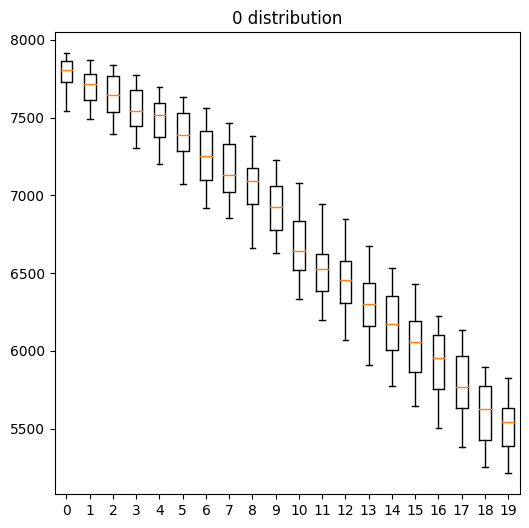

In [48]:
fig, axs = plt.subplots(figsize=(6, 6))
title = '0 distribution'
axs.set_title(title)
axs.boxplot(dataa, labels=cnot_vals)
plt.show(fig)
if not path_exists:
    fig.savefig('{}/{}.png'.format(path, title))

